In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from math import nan

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

import sys
from qtrendutils import colormap_utils as mycolors
from qtrendutils import averaging_utils as avg
from qtrendutils import colorbar_utils as cbars

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
trendpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"

### Land Fraction

In [4]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Aridity Index

In [5]:
pet_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PET_Terraclim_1980_2020.nc")
pet_tc = pet_tc.mean('time')
ppt_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PPT_Terraclim_1980_2020.nc")
ppt_tc = ppt_tc.mean('time')
aridity = ppt_tc.ppt / pet_tc.pet
aridity['lon'] = landfrac.lon ; aridity['lat'] = landfrac.lat

In [6]:
aridmask = landfrac.where( (aridity > 0.05) & (aridity < 0.5), nan)
humidmask = landfrac.where( (aridity >= 0.5), nan)
hyperaridmask = landfrac.where( (aridity <= 0.05), nan)

aridmask = aridmask.where( aridmask.lat > -60, nan)
humidmask = humidmask.where( humidmask.lat > -60, nan)
hyperaridmask = hyperaridmask.where(hyperaridmask.lat > -60, nan)

landmask = landfrac.where( landfrac.lat > -60, nan)

### Read in the observational data

In [7]:
era5map = xr.open_dataset(trendpath+"vptrends_ERA5.nc")
era5map['lon'] = landfrac.lon ; era5map['lat'] = landfrac.lat
era5vp_map = era5map.vp
era5q_map = era5map.q

era5vp_clim = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_1990_clims/vpclims_ERA5.nc")
era5vp_clim['lon'] = landfrac.lon ; era5vp_clim['lat'] = landfrac.lat
era5q_clim = era5vp_clim.q

era5landT_trend = era5map.T2m*landmask
era5landT_trend_m = avg.cosweightlonlat(era5landT_trend, 0, 360, -90, 90)

era5_q_trend_pcnt = (era5q_map / era5q_clim)*100.
era5_q_trend_pcnt_norm = era5_q_trend_pcnt / era5landT_trend_m

gpcc_map = xr.open_dataset(trendpath+'prtrends_GPCC.nc')
gpcc_map['lon'] = landfrac.lon ; gpcc_map['lat'] = landfrac.lat

### Read in the model based map data

In [8]:
#-----CMIP6
cmip6vp_map = xr.open_dataset(trendpath+'vptrends_CMIP6.nc')
cmip6vp_map['lon'] = landfrac.lon ; cmip6vp_map['lat'] = landfrac.lat
cmip6q_map = cmip6vp_map.q

cmip6vp_clim = xr.open_dataset('/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_1990_clims/vpclims_CMIP6.nc')
cmip6vp_clim['lon'] = landfrac.lon ; cmip6vp_clim['lat'] = landfrac.lat
cmip6q_clim = cmip6vp_clim.q

cmip6_q_trend_pcnt = (cmip6q_map / cmip6q_clim)*100.
#----Issues with normalizing locally since some T trends are near zero
#cmip6_q_trend_pcnt_norm = cmip6_q_trend_pcnt / cmip6vp_map.tas
cmip6_t_trend = avg.cosweightlonlat(cmip6vp_map.tas*landfrac,0,360,-90,90)
cmip6_q_trend_pcnt_norm = cmip6_q_trend_pcnt / cmip6_t_trend

cmip6pr_map = xr.open_dataset(trendpath+'prtrends_CMIP6.nc')*86400.
cmip6pr_map['lon'] = landfrac.lon ; cmip6pr_map['lat'] = landfrac.lat
cmip6pr_map = cmip6pr_map.pr

cmip6q_map_1mem = cmip6_q_trend_pcnt_norm.isel(member=0)
cmip6pr_map_1mem = cmip6pr_map.isel(member=0)
cmip6vp_map_1mem = cmip6vp_map.vp.isel(member=0)

cmip6q_map = cmip6_q_trend_pcnt_norm.stack(z=['model','member'])
cmip6pr_map = cmip6pr_map.stack(z=['model','member'])
cmip6vp_map = cmip6vp_map.vp.stack(z=['model','member'])

#------CMIP5
cmip5vp_map = xr.open_dataset(trendpath+'vptrends_CMIP5.nc')
cmip5vp_map['lon'] = landfrac.lon ; cmip5vp_map['lat'] = landfrac.lat
cmip5q_map = cmip5vp_map.q

cmip5vp_clim = xr.open_dataset('/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_1990_clims/vpclims_CMIP5.nc')
cmip5vp_clim['lon'] = landfrac.lon ; cmip5vp_clim['lat'] = landfrac.lat
cmip5q_clim = cmip5vp_clim.q

cmip5_q_trend_pcnt = (cmip5q_map / cmip5q_clim)*100.
#----Issues with normalizing locally since some T trends are near zero
#cmip6_q_trend_pcnt_norm = cmip6_q_trend_pcnt / cmip6vp_map.tas
cmip5_t_trend = avg.cosweightlonlat(cmip5vp_map.tas*landfrac,0,360,-90,90)
cmip5_q_trend_pcnt_norm = cmip5_q_trend_pcnt / cmip5_t_trend

cmip5pr_map = xr.open_dataset(trendpath+'prtrends_CMIP5.nc')*86400.
cmip5pr_map['lon'] = landfrac.lon ; cmip5pr_map['lat'] = landfrac.lat
cmip5pr_map = cmip5pr_map.pr

cmip5q_map_1mem = cmip5_q_trend_pcnt_norm.isel(member=0)
cmip5pr_map_1mem = cmip5pr_map.isel(member=0)
cmip5vp_map_1mem = cmip5vp_map.vp.isel(member=0)

cmip5q_map = cmip5q_map.stack(z=['model','member'])
cmip5pr_map = cmip5pr_map.stack(z=['model','member'])
cmip5vp_map = cmip5vp_map.vp.stack(z=['model','member'])

testpoint = cmip6vp_map.sel(lon=180, lat=0, method='nearest')

cmip6q_map = cmip6q_map.where( ~np.isnan(testpoint), drop=True )
cmip6pr_map = cmip6pr_map.where( ~np.isnan(testpoint), drop=True )
cmip6vp_map = cmip6vp_map.where( ~np.isnan(testpoint), drop=True )

testpoint = cmip5vp_map.sel(lon=180, lat=0, method='nearest')

cmip5q_map = cmip5q_map.where( ~np.isnan(testpoint), drop=True )
cmip5pr_map = cmip5pr_map.where( ~np.isnan(testpoint), drop=True )
cmip5vp_map = cmip5vp_map.where( ~np.isnan(testpoint), drop=True )

### Work out the deviations of ERA5 from the CMIP6 relation with precipitation (using all models and all members)

In [9]:
aglobal6 = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size]) ; bglobal6 = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size])
aglobal6[:,:] = nan ; bglobal6[:,:] = nan

for ilon in np.arange(0,cmip6pr_map.lon.size,1):
    for ilat in np.arange(0,cmip6pr_map.lat.size,1):
        if (landfrac[ilat,ilon] == 1):
            a_t, b_t = linfit.linfit_xy(cmip6pr_map.isel(lon=ilon, lat=ilat), cmip6vp_map.isel(lon=ilon, lat=ilat))
            aglobal6[ilat,ilon] = a_t ; bglobal6[ilat,ilon] = b_t
            
aglobal5 = np.zeros([cmip5pr_map.lat.size, cmip5pr_map.lon.size]) ; bglobal5 = np.zeros([cmip5pr_map.lat.size, cmip5pr_map.lon.size])
aglobal5[:,:] = nan ; bglobal5[:,:] = nan

for ilon in np.arange(0,cmip5pr_map.lon.size,1):
    for ilat in np.arange(0,cmip5pr_map.lat.size,1):
        if (landfrac[ilat,ilon] == 1):
            a_t, b_t = linfit.linfit_xy(cmip5pr_map.isel(lon=ilon, lat=ilat), cmip5vp_map.isel(lon=ilon, lat=ilat))
            aglobal5[ilat,ilon] = a_t ; bglobal5[ilat,ilon] = b_t
            
aglobal6 = xr.DataArray(aglobal6, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='aglobal6')
bglobal6 = xr.DataArray(bglobal6, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='bglobal6')

aglobal5 = xr.DataArray(aglobal5, coords=[cmip5pr_map.lat, cmip5pr_map.lon], dims=['lat','lon'], name='aglobal5')
bglobal5 = xr.DataArray(bglobal5, coords=[cmip5pr_map.lat, cmip5pr_map.lon], dims=['lat','lon'], name='bglobal5')

vppredict6 = aglobal6 + bglobal6 *cmip6pr_map
residuals6 = cmip6vp_map - vppredict6
residualstdev6 = residuals6.std(dim='z')

vppredict5 = aglobal5 + bglobal5 *cmip5pr_map
residuals5 = cmip5vp_map - vppredict5
residualstdev5 = residuals5.std(dim='z')

vppredict_gpcc6 = aglobal6 + bglobal6*gpcc_map
vppredict_gpcc5 = aglobal5 + bglobal5*gpcc_map

era5vptrenddif_gpcc6 = era5map.vp - np.array(vppredict_gpcc6.pr)
era5vptrenddif_gpcc5 = era5map.vp - np.array(vppredict_gpcc5.pr)


vpshading_afterp_gpcc6 = era5map.vp*nan
vpshading_afterp_gpcc6 = vpshading_afterp_gpcc6.where( (era5vptrenddif_gpcc6 > 2*residualstdev6) | (era5vptrenddif_gpcc6 < -2*residualstdev6),1)
vpshading_afterp_gpcc6 = vpshading_afterp_gpcc6.where( np.array(landfrac) > 0, nan)

vpshading_afterp_gpcc5 = era5map.vp*nan
vpshading_afterp_gpcc5 = vpshading_afterp_gpcc5.where( (era5vptrenddif_gpcc5 > 2*residualstdev5) | (era5vptrenddif_gpcc5 < -2*residualstdev5),1)
vpshading_afterp_gpcc5 = vpshading_afterp_gpcc5.where( np.array(landfrac) > 0, nan)

### Set up the joint pdf

In [10]:
def setupjointpdf( vpdata, svpdata, weights ):
    X, Y = np.mgrid[-1.500:1.525:122j, -25:25.5:102j] # probabilities represent per (0.025 precip, 0.5%/K)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    xplot = vpdata.flatten()
    yplot = svpdata.flatten()
    inputdata = np.vstack([xplot, yplot])
    kernel = stats.gaussian_kde(inputdata, weights=weights)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z = np.moveaxis(Z, 1, 0)
    Xout = X[:,0] ; Yout = Y[0,:]
    return Z, Xout, Yout

### Pick out arid regions for first member for each model

In [11]:
cmip6q_arid = cmip6q_map_1mem*aridmask ; cmip6pr_arid = cmip6pr_map_1mem*aridmask
cmip6q_arid = cmip6q_arid.stack(z=['lon','lat']).dropna('z')
cmip6pr_arid = cmip6pr_arid.stack(z=['lon','lat']).dropna('z')

cmip6q_arid_allmem = cmip6q_map*aridmask ; cmip6pr_arid_allmem = cmip6pr_map*aridmask
cmip6q_arid_allmem = cmip6q_arid_allmem.stack(loc=['lon','lat']).dropna('loc')
cmip6pr_arid_allmem = cmip6pr_arid_allmem.stack(loc=['lon','lat']).dropna('loc')

cmip5q_arid = cmip5q_map_1mem*aridmask ; cmip5pr_arid = cmip5pr_map_1mem*aridmask
cmip5q_arid = cmip5q_arid.stack(z=['lon','lat']).dropna('z')
cmip5pr_arid = cmip5pr_arid.stack(z=['lon','lat']).dropna('z')

cmip5q_arid_allmem = cmip5q_map*aridmask ; cmip5pr_arid_allmem = cmip5pr_map*aridmask
cmip5q_arid_allmem = cmip5q_arid_allmem.stack(loc=['lon','lat']).dropna('loc')
cmip5pr_arid_allmem = cmip5pr_arid_allmem.stack(loc=['lon','lat']).dropna('loc')

#----basing which grid points to drop on GPCC since it has a few extra NaN's around the coast
gpcc_arid = gpcc_map*aridmask 
gpcc_arid = gpcc_arid.stack(z=['lon','lat'])#.dropna('z')

era5_arid = era5_q_trend_pcnt_norm*aridmask
era5_arid = era5_arid.stack(z=['lon','lat'])
era5_arid = era5_arid.where( ~np.isnan(gpcc_arid.pr), drop=True)
gpcc_arid = gpcc_arid.dropna("z")

# Drop lingering NaN's
idrop = np.argwhere( np.isnan(np.array(gpcc_arid.pr)) | np.isnan(np.array(era5_arid)) )
gpcc_arid = gpcc_arid.drop_isel(z=idrop)
era5_arid = era5_arid.drop_isel(z=idrop)

### Joint PDFs cosine weighting

In [12]:
for imodel in np.arange(0,cmip6q_arid.model.size,1):
    prdat = cmip6pr_arid.isel(model=imodel)
    qdat = cmip6q_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    zi, x, y = setupjointpdf(np.array(prdat), np.array(qdat), w)
    if (imodel == 0):
        zcmip6_weighted = xr.DataArray(np.zeros([cmip6pr_arid.model.size, len(y), len(x)]),
                                       coords=[cmip6pr_arid.model, y, x], dims=['model','y','x'], name='cmip6_prob')
    zcmip6_weighted[imodel,:,:] = zi[:,:]
    
for imodel in np.arange(0,cmip5q_arid.model.size,1):
    prdat = cmip5pr_arid.isel(model=imodel)
    qdat = cmip5q_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    zi, x, y = setupjointpdf(np.array(prdat), np.array(qdat), w)
    if (imodel == 0):
        zcmip5_weighted = xr.DataArray(np.zeros([cmip5pr_arid.model.size, len(y), len(x)]),
                                       coords=[cmip5pr_arid.model, y, x], dims=['model','y','x'], name='cmip5_prob')
    zcmip5_weighted[imodel,:,:] = zi[:,:]
        
zgpcc, x, y = setupjointpdf(np.array(gpcc_arid.pr), np.array(era5_arid), np.cos(np.deg2rad(era5_arid.lat)))

### Bin the data

In [13]:
bins = np.arange(-0.325,0.325,0.05)

digitized = np.digitize(gpcc_arid.pr, bins)
weights = np.cos(np.deg2rad(gpcc_arid.lat))
pr_obs_gpcc = [ ( ((gpcc_arid.pr[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
q_obs_gpcc = [ ( ((era5_arid[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]

pr_cmip6 = xr.DataArray(np.zeros([cmip6q_arid.model.size, len(bins)]), coords=[cmip6q_arid.model, bins], dims=['model','bin'], name='pr')
q_cmip6 = xr.DataArray(np.zeros([cmip6q_arid.model.size, len(bins)]), coords=[cmip6q_arid.model, bins], dims=['model','bin'], name='q')

for imodel in np.arange(0,cmip6q_arid.model.size,1):
    prdat = cmip6pr_arid.isel(model=imodel)
    qdat = cmip6q_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    digitized = np.digitize(prdat, bins)
    pr_cmip6[imodel,:] =  [ ( ((prdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    q_cmip6[imodel,:] = [ ( ((qdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    

pr_cmip5 = xr.DataArray(np.zeros([cmip5q_arid.model.size, len(bins)]), coords=[cmip5q_arid.model, bins], dims=['model','bin'], name='pr')
q_cmip5 = xr.DataArray(np.zeros([cmip5q_arid.model.size, len(bins)]), coords=[cmip5q_arid.model, bins], dims=['model','bin'], name='q')

for imodel in np.arange(0,cmip5q_arid.model.size,1):
    prdat = cmip5pr_arid.isel(model=imodel)
    qdat = cmip5q_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    digitized = np.digitize(prdat, bins)
    pr_cmip5[imodel,:] =  [ ( ((prdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    q_cmip5[imodel,:] = [ ( ((qdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]

In [14]:
def setup_q_vs_pr(x1, x2, y1, y2, titlestr, yticks=True):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_ylim(-13,17)
    ax.set_xlim(-0.4,0.4)
    
    ax.plot([0,0],[-13,17], color='black')
    ax.plot([-0.4,0.4],[0,0], color='black')
    
    ax.set_yticks([-10,-5,0,5,10,15])
    ax.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])

    if (yticks):  
        ax.set_yticklabels(['-10','-5','0','5','10','15'], fontsize=14)
        ax.set_ylabel('Specific Humidity Trend (%/K)', fontsize=14)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '], fontsize=14)
        
    ax.set_xticklabels(['-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4'], fontsize=14)
    
    ax.set_xlabel('Precipitation trend (mm/day/41y)', fontsize=14)
    ax.set_title(titlestr, fontsize=16)
    
    return ax

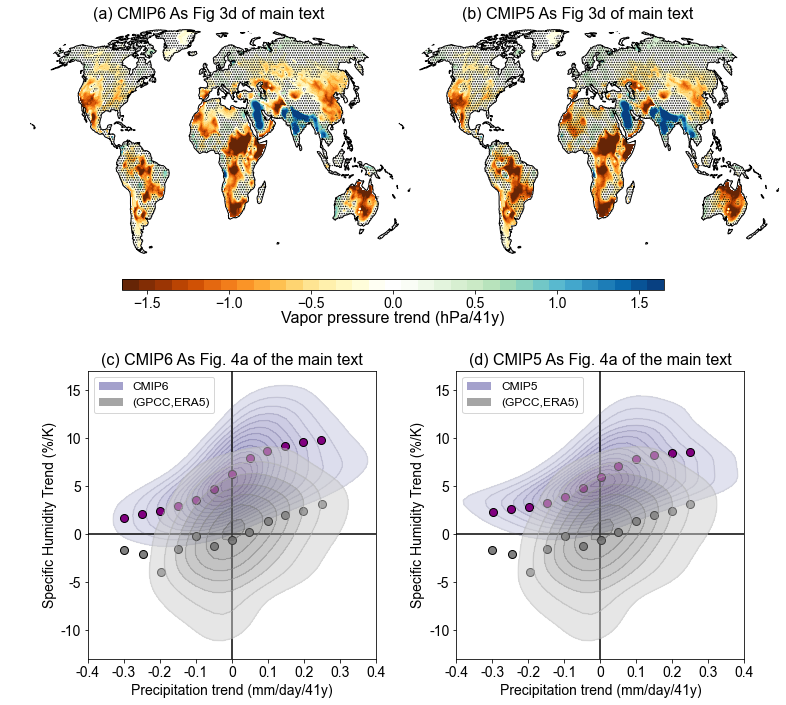

In [15]:
fig = plt.figure(figsize=(16,16))

#ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vp_map*np.array(landfrac), era5vp_map.lon, era5vp_map.lat, 0.1, -1.6, 1.6,
#                                                            '(a) ERA5 VP trend'

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcc6*np.array(landfrac), era5vptrenddif_gpcc6.lon, era5vptrenddif_gpcc6.lat,
                                                            0.1,-1.6,1.6,'(a) CMIP6 As Fig 3d of main text',0,0.35,0.45,0.65,cmap='precip', signifdat=vpshading_afterp_gpcc6, stipplesignif=True, fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcc5*np.array(landfrac), era5vptrenddif_gpcc5.lon, era5vptrenddif_gpcc5.lat,
                                                            0.1,-1.6,1.6,'(b) CMIP5 As Fig 3d of main text',0.32,0.67,0.45,0.65,cmap='precip', signifdat=vpshading_afterp_gpcc5, stipplesignif=True, fontsize=16)

ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.1,0.57,0.42,0.43,cmap='precip')

#------CMIP6 joint pdfs
ax = setup_q_vs_pr(0.07,0.32,0.1,0.35,'(c) CMIP6 As Fig. 4a of the main text')

cmin=0.04 ; cmax=0.42 ; ci=0.02
ncontours = (cmax - cmin)/ci + 1

colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zgpcc, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCC, ERA5)')
ax.contour(x, y, zgpcc, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmipcolors=colors
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcmip6_weighted.mean('model'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zcmip6_weighted.mean('model'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
cmiplegend = Rectangle((0.95,0.95),5,3,facecolor=colors[5])

plt.plot(pr_obs_gpcc, q_obs_gpcc, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_cmip6.mean('model'), q_cmip6.mean('model'),"o", markeredgecolor='black', markerfacecolor='purple', markersize=8)

legendparts = [cmiplegend, obslegend]
legendlabels = ['CMIP6','(GPCC,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})


#-------CMIP5 joint pdfs
ax = setup_q_vs_pr(0.39,0.64,0.1,0.35,'(d) CMIP5 As Fig. 4a of the main text')

cmin=0.04 ; cmax=0.42 ; ci=0.02
ncontours = (cmax - cmin)/ci + 1

colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zgpcc, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCC, ERA5)')
ax.contour(x, y, zgpcc, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmipcolors=colors
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcmip5_weighted.mean('model'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zcmip5_weighted.mean('model'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
cmiplegend = Rectangle((0.95,0.95),5,3,facecolor=colors[5])

plt.plot(pr_obs_gpcc, q_obs_gpcc, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_cmip5.mean('model'), q_cmip5.mean('model'),"o", markeredgecolor='black', markerfacecolor='purple', markersize=8)

legendparts = [cmiplegend, obslegend]
legendlabels = ['CMIP5','(GPCC,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})


fig.savefig(plotpath+'figS20.pdf', bbox_inches='tight', facecolor='white')
